# Quantum Monte Carlo For The Long Range XY Model

In this notebook we will simulate the power law decay XY model in 1d with periodic boundaries using Exact Diagonalization (ED) as well as long range Quantum Monte Carlo (QMC): 

$$
H = -J \sum_{i < j} 1/r_{ij}^\alpha \left(S_i^x S_j^x + S_i^y S_j^y \right)
$$

In doing so, we exhibit multiple different entry points that can be used with the Heisenberg Ion package.  

The input file XY_long_range.txt specifies the settings required to simulate this system with the power law interactions above. The file lists the following parameters:

In [1]:
input_file = "./input_files/long_range_XY.txt"
with open(input_file, 'r') as f:
    file_contents = f.read()
    print(file_contents)

simulator	long_range_qmc

# System Parameters
hamiltonian_name	XY
boundary	periodic
interaction_range	long_range
interaction_type	power_law
alpha	1.0
spatial_dimension	1d
lattice_type	rectangular
N	11
J	1.0

# Simulation Parameters
T	0.05
equilibration_steps	100000
simulation_steps	100000
operator_list_update_multiplier	1.05
loop_type	deterministic

# Misc.
root_folder	./results
output_folder_name	long_range_qmc
uuid	xy_example
track_spin_configurations	True
write_final_spin_configuration	False
number_of_threads	1

# Initial Configuration Parameters
initial_configuration_index	0
initial_operator_list_size	-1

# Seeds
initial_config_seed	845886
disconnected_spin_flip_seed	255995
off_diagonal_update_seed	893908
metropolis_insert_seed	222288
metropolis_remove_seed	625433
diagonal_update_seed	419814
exit_leg_seed	525338



In the above, note that we have selected the `long_range_qmc` simulator to call the required QMC engine for long range interactions. 

We will use $N=11$ for this calculation with power law exponent $\alpha = 1.0$. The results of this calculation will be stored in the directory `./results/long_range_qmc/xy_example`. The last two directories will be created by the simulator to contain the estimator outputs and the shot data (which will be recorded because the `track_spin_configurations` parameter is set to `True`) in csv files. 

In [2]:
from oqd_heisenberg_ion.interface.main import main

main(["-i", input_file]);

Now, we can use the post processing utilities to compute expectation values using the estimator data:

In [3]:
import os

import numpy as np
from matplotlib import pyplot as plt

from oqd_heisenberg_ion.common.postprocess import utils as post_proc

estimators_file = os.path.join("./results/long_range_qmc/xy_example", "qmc_output/estimators.csv")
mc_steps, energy, magnetization, stiffness = np.loadtxt(estimators_file, delimiter=",", skiprows=2, unpack=True)
qmc_energy_mean, qmc_energy_error = post_proc.statistics_binning(energy, auto_corr_drop=20, eq_drop=0)

print(qmc_energy_mean)
print(qmc_energy_error)

-6.908992
0.012007605165938991


It is instructive to compare these energy estimates with Exact Diagonalization (ED) since the system size is relatively small in this example. 

Instead of using an input file, we can also simply define the parameters in a code block/script:

In [4]:
simulator = 'exact_diagonalization'

# System Parameters
hamiltonian_name = 'XY'
boundary = 'periodic'
interaction_range = 'long_range'
interaction_type = 'power_law'
alpha = 1.0
spatial_dimension = '1d'
lattice_type = 'rectangular'
N = 11
J = 1.0
theta=0.0

root_folder = './results'
output_folder_name = 'exact_diagonalization'
uuid = 'xy_example'

The above block defines the system and output directory parameters. Note that we have added another system parameter: `theta=0.0`. This defines the boundary phase twist on the XY term and is useful for computing the spin stiffness of the system. It is important to note that the phase twist changes the Hamiltonian and the corresponding ground state energy. Since we are interested in the energy of the Hamiltonian without the twist, we set this to $0.0$. 

Above, we have also specified the `simulator` to be `exact_diagonalization` and changed the `output_folder_name` to `exact_diagonalization`. 

Now, we can use these as key word arguments as follows:

In [5]:
from oqd_heisenberg_ion.interface.orchestrator import Orchestrator

orchestrator = Orchestrator(simulator=simulator, hamiltonian_name=hamiltonian_name, boundary=boundary, 
            interaction_range=interaction_range, interaction_type=interaction_type, 
            alpha=alpha, spatial_dimension=spatial_dimension, lattice_type=lattice_type,
            N=N, J=J, root_folder=root_folder, output_folder_name=output_folder_name, 
            uuid=uuid, theta=theta)
orchestrator.simulate();

Now, we can read in the output file produced by the above ED calculation and compute the equilibrium energy: 

$$
\langle E \rangle = \frac{1}{Z}\sum_{i} E_i e^{-E_i/T}
$$

$Z$ in the above equation is partition function: 

$$
Z = \sum_{i} e^{-E_i/T}

In [6]:
import numpy as np

from oqd_heisenberg_ion.common.postprocess import utils as post_proc

ed_output_file = "./results/exact_diagonalization/xy_example/ed_output/energies.csv"
spectrum = np.loadtxt(ed_output_file, skiprows=1)

T = 0.05 # The temperature that was used for the QMC calculation
ed_energy = post_proc.ed_energy(spectrum, T)

print(ed_energy)
print(qmc_energy_mean + qmc_energy_error)
print(qmc_energy_mean - qmc_energy_error)

-6.941675063094317
-6.89698439483406
-6.920999605165939


The QMC energy estimate and the ED estimate agree within standard error for $\alpha=1.0$. 

It is also interesting to examine the behavior of the energy as a function of temperature in the presence of long range interactions. For this, we need to run more QMC calculations. 

For this calculation, instead of using an input file or the Orchestrator class, we will specify the inputs, call the preprocessor and then simulate the system to exhibit that workflow. 

In [7]:
from oqd_heisenberg_ion.common.inputs.input_reader import InputReader
from oqd_heisenberg_ion.common.preprocessor.factory import PreprocessorFactory

simulator = 'long_range_qmc'

inputs = InputReader(simulator=simulator)

# First, we specify the system
inputs.read_kwarg_inputs(
    hamiltonian_name = "XY",
    boundary = "periodic",
    interaction_range = "long_range",
    interaction_type = "power_law",
    alpha = 1.0,
    spatial_dimension='1d',
    lattice_type = "rectangular",
    N = 11,
    J = 1.0)

# Provide sampling inputs
inputs.read_kwarg_inputs(
    equilibration_steps=100000,
    simulation_steps=100000,
    operator_list_update_multiplier=1.5,
    loop_type='deterministic',
    initial_configuration_index=0,
    initial_operator_list_size=-1,
    track_spin_configurations=True,
    write_final_spin_configuration=False)

# output directory inputs
inputs.read_kwarg_inputs(root_folder="./results")

# Provide the list of temperatures to be simulated
T_list = [1/(0.5*i + 0.5) for i in range(10)]
inputs.read_kwarg_inputs(T=T_list, number_of_threads=len(T_list))

parameter_set_list = inputs.parameter_set_list

preprocessor = PreprocessorFactory.create(simulator, parameter_set_list)

driver_inputs = preprocessor.preprocess();

In the above, note that we did not specify a uuid. If we did, we would need to provide a unique id for each value of T we want to simulate. They will be generated automatically. Also, we have changed the output_folder_name because output overrides are prohibited. 

Finally, we provided the entire list of temperature to be simulated and set the number of threads to the length of the list so all the calculations could proceed in parellel.

Now, we can call the driver to simulate the systems.

In [8]:
from oqd_heisenberg_ion.common.driver.factory import DriverFactory

driver = DriverFactory.create(simulator, preprocessor.simulation_folder, driver_inputs)
driver.simulate();

We can extract the automatically generated output paths from the preprocessor to analyze the QMC results. 

Then, we can use the eigenvalues of the Hamiltonian we computed using ED before to compute the ED equilibrium energy as a function of temperature. 

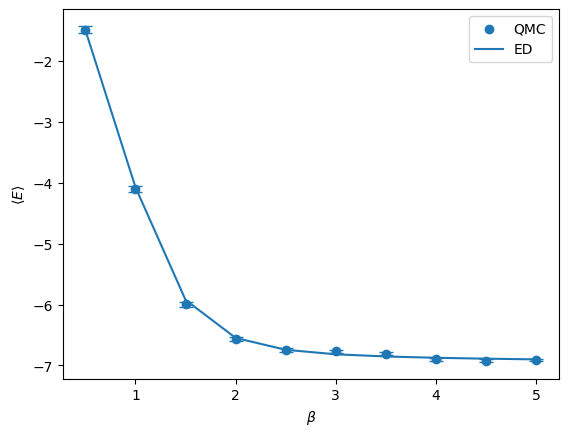

In [9]:
from matplotlib import pyplot as plt

from oqd_heisenberg_ion.common.postprocess import utils as post_proc

num_param_sets = preprocessor.num_parameter_sets
run_dirs = [preprocessor.processed_configs[i]["misc"]["run_folder"] for i in range(num_param_sets)]

# The estimator data is always stored in the 'qmc_output' folder, with filename 'estimators.csv'
estimator_files = [os.path.join(run_folder, "qmc_output/estimators.csv") for run_folder in run_dirs]

energy_means = []
energy_errs = []
ed_energies = []
beta_list = []
for i in range(num_param_sets):
    estimator_filepath = estimator_files[i]
    data = np.loadtxt(estimator_filepath, skiprows=2, delimiter=",")
    E_avg, E_std_err = post_proc.statistics_binning(data[:,1], 20, 0)
    energy_means.append(E_avg)
    energy_errs.append(E_std_err)

    ed_energy = post_proc.ed_energy(spectrum, T_list[i])
    ed_energies.append(ed_energy)
    beta_list.append(1.0/T_list[i])

plt.figure()
plt.scatter(beta_list, energy_means, label='QMC')
plt.errorbar(beta_list, energy_means, energy_errs, capsize=5, fmt='None')
plt.plot(beta_list, ed_energies, label='ED')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$ \langle E \rangle $')
plt.legend()
plt.show()

The QMC and ED energies agree as a function of $T$, indicating good QMC convergence. 